In [1]:
import pandas as pd
from scripts.extract import *
from scripts.clean import *
from scripts.plotly_plots import *
from scripts.mpl_plots import *
from scripts.stats import *
import warnings

warnings.filterwarnings("ignore")

# Data Loading and Cleaning:

* Loading data from CSV and GeoJSON files.
* Cleaning and preprocessing the storm database, including handling missing values and converting data types.
* Reading a shapefile for U.S. states and processing the data.
* Natural disasters datasets are from NOAA's strom database https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/
* These datasets are splited by year. So we need to read them one by one.

In [2]:
storm_database = read_all_zipped_csv("/dataset/*.csv.gz")
storm_database.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,198004,13,30,198004,13,30,NaN,10046120,LOUISIANA,22.0,...,0.0,NaN,NaN,31.10,-92.40,NaN,NaN,NaN,NaN,PUB
1,198005,29,1410,198005,29,1410,NaN,10065016,NEBRASKA,31.0,...,0.0,NaN,NaN,42.78,-97.80,NaN,NaN,NaN,NaN,PUB
2,198007,22,10,198007,22,10,NaN,10065375,NEBRASKA,31.0,...,0.0,NaN,NaN,40.05,-101.53,NaN,NaN,NaN,NaN,PUB
3,198009,3,1830,198009,3,1830,NaN,10054907,MINNESOTA,27.0,...,0.0,NaN,NaN,44.78,-95.22,NaN,NaN,NaN,NaN,PUB
4,198009,17,830,198009,17,830,NaN,9975991,ALABAMA,1.0,...,0.0,NaN,NaN,32.93,-87.17,NaN,NaN,NaN,NaN,PUB


In [3]:
storm_database.shape

(1782208, 51)

In [4]:
storm_database.iloc[0:8,7:18]

,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME
0,10046120,LOUISIANA,22.0,1980,April,Hail,C,79,RAPIDES,T,13-APR-80 00:30:00
1,10065016,NEBRASKA,31.0,1980,May,Hail,C,107,KNOX,NG,29-MAY-80 14:10:00
2,10065375,NEBRASKA,31.0,1980,July,Thunderstorm Wind,C,57,DUNDY,ATA,22-JUL-80 00:10:00
3,10054907,MINNESOTA,27.0,1980,September,Thunderstorm Wind,C,129,RENVILLE,NG,03-SEP-80 18:30:00
4,9975991,ALABAMA,1.0,1980,September,Thunderstorm Wind,C,7,BIBB,TS,17-SEP-80 08:30:00
5,9975992,ALABAMA,1.0,1980,November,Tornado,C,3,BALDWIN,NaN,23-NOV-80 14:30:00
6,10075651,NEW YORK,36.0,1980,June,Hail,C,37,GENESEE,RY,26-JUN-80 18:50:00
7,10058560,MISSOURI,29.0,1980,May,Thunderstorm Wind,C,39,CEDAR,T,26-MAY-80 16:55:00


Data cleaning mainly focused on:
* drop events without damage value
* drop disasters events that happened in Marine, or in American overseas territorie, like Guam, Virgin Islands, American Samoa.

In [5]:
storm_database['DAMAGE_P'] = storm_database['DAMAGE_PROPERTY'].apply(convert_to_numeric)
storm_database['DAMAGE_C'] = storm_database['DAMAGE_CROPS'].apply(convert_to_numeric)
storm_database.dropna(subset=['DAMAGE_P','DAMAGE_C'], inplace=True)
storm_database['DAMAGE_P'] =  storm_database['DAMAGE_P'] / 1000000
storm_database['DAMAGE_C'] =  storm_database['DAMAGE_C'] / 1000000
storm_database['DAMAGE'] = storm_database['DAMAGE_P'] + storm_database['DAMAGE_C']
storm = storm_database.copy()

# Exploratory Data Analysis (EDA):

* Analyzing the frequency and damage of natural disasters over the years.
* Visualizing the top 5 most common climate disasters and the top 5 damage-causing climate disasters.
* Creating maps to show the distribution of disasters by state and year.

Disasters analysis and visualization

In [6]:
storm['STATE'] = storm['STATE'].str.title()
state_freq = storm.groupby('STATE')['EVENT_ID'].count()

In [7]:
gdf = read_gpd_file("/dataset/cb_2022_us_state_500k")
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198573403,726463825,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
1,46,01785534,0400000US46,46,SD,South Dakota,00,196341552329,3387681983,"POLYGON ((-104.05788 44.99761, -104.05078 44.9..."
2,06,01779778,0400000US06,06,CA,California,00,403673617862,20291712025,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
3,21,01779786,0400000US21,21,KY,Kentucky,00,102266581101,2384240769,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ..."
4,01,01779775,0400000US01,01,AL,Alabama,00,131185042550,4582333181,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."


In [8]:
state_gdf = list(gdf.NAME.unique())
state_storm = state_freq.index.to_list()
state_same = []
for s in state_storm:
    if s in state_gdf:
        state_same.append(s)
state_gdf_l = set(state_gdf) - set(state_same)
state_storm_l = set(state_storm) - set(state_same)
print(state_gdf_l)
print(state_storm_l)

{'District of Columbia', 'United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands'}
{'Lake Ontario', 'St Lawrence R', 'Atlantic South', 'Lake Michigan', 'Lake Huron', 'Lake Superior', 'E Pacific', 'Gulf Of Alaska', 'Lake Erie', 'Virgin Islands', 'Gulf Of Mexico', 'Hawaii Waters', 'District Of Columbia', 'Atlantic North', 'Lake St Clair'}


* We get over 1 million disaster events after data cleaning

In [9]:
storm = storm[ ~ storm['STATE'].isin(state_storm_l)]
storm = storm[ ~ storm['STATE'].isin(['American Samoa','Guam'])]
storm.shape

(1027339, 54)

In [10]:
gdf_state = gdf[['STUSPS','NAME']]
storm = pd.merge(storm, gdf_state, left_on='STATE', right_on='NAME', how='left')
storm['STUSPS'].isnull().sum()

0

In [11]:
year_freq = storm.groupby('YEAR')['EVENT_ID'].count()
year_list = year_freq.index.to_list()
year_freq = list(year_freq)
year_damage = storm.groupby('YEAR')['DAMAGE'].sum()
year_damage = list(year_damage)
year_damage = [ damage / 1000 for damage in year_damage]

In [12]:
plot_bar_and_line(year_list, year_damage, year_freq, 'Damage($Billions)', 'Frequency', 'Frequency and Damage of Natural Disasters 1980-2023', 'Year', 'Damage($Billions)', 'Frequency', "Frequency_and_Damage_of_Natural_Disasters_1980-2023.html")

* The most common disaster type isn't the most damage-causing disaster.

In [13]:
event_type_freq = storm.groupby(['EVENT_TYPE'])['EVENT_ID'].count()
event_type_freq.sort_values(ascending = False, inplace=True)
event_type_top = event_type_freq[:5]

In [14]:
plot_bar_chart(event_type_top.index.to_list(), event_type_top.values, 'Top 5 Most Common Climate Disasters','Frequency','Top 5 Most Common Climate Disasters.html')

In [15]:
event_type_damage = storm.groupby(['EVENT_TYPE'])['DAMAGE'].sum()
event_type_damage.sort_values(ascending = False, inplace=True)
event_type_damage = event_type_damage[:5]
event_type_damage_label = list(event_type_damage.index)
event_type_damage = [round(damage / 1000,1) for damage in event_type_damage]
plot_bar_chart(event_type_damage_label, event_type_damage, 'Top 5 Damage-causing Climate Disasters','Damage ($Billions)','Top 5 Damage-causing Climate Disasters.html')

In [16]:
state_freq = storm.groupby('STATE')['EVENT_ID'].count()
state_damage = storm.groupby('STATE')['DAMAGE'].sum()
state_disaster = pd.merge(state_freq, state_damage, left_index=True, right_index=True)
state_disaster.reset_index(inplace=True)
state_disaster.rename(columns={'EVENT_ID':'EVENT', 'STATE':'state'}, inplace=True)
state_disaster['DAMAGE'] = state_disaster['DAMAGE']/1000

In [17]:
gdf = gdf.merge(state_disaster,left_on='NAME',right_on='state')

* Disasters events are relatively concentrated, primarily in the southern United States (e.g. Texas) and central-western regions.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


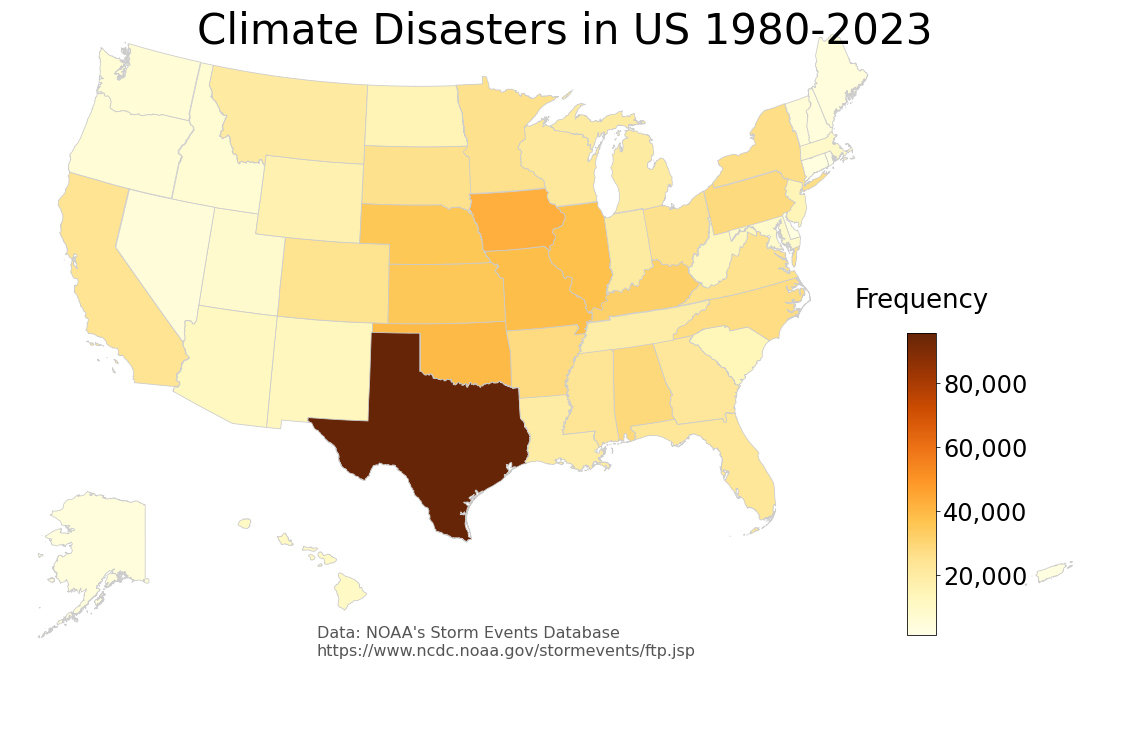

In [18]:
variable = 'EVENT'
label = 'Frequency'
save_name = 'disasters_frequency_by_state_1980_2023.png'
plot_disasters_map(gdf, variable, label, save_name, 'Climate Disasters in US 1980-2023', "Data: NOAA's Storm Events Database\nhttps://www.ncdc.noaa.gov/stormevents/ftp.jsp")

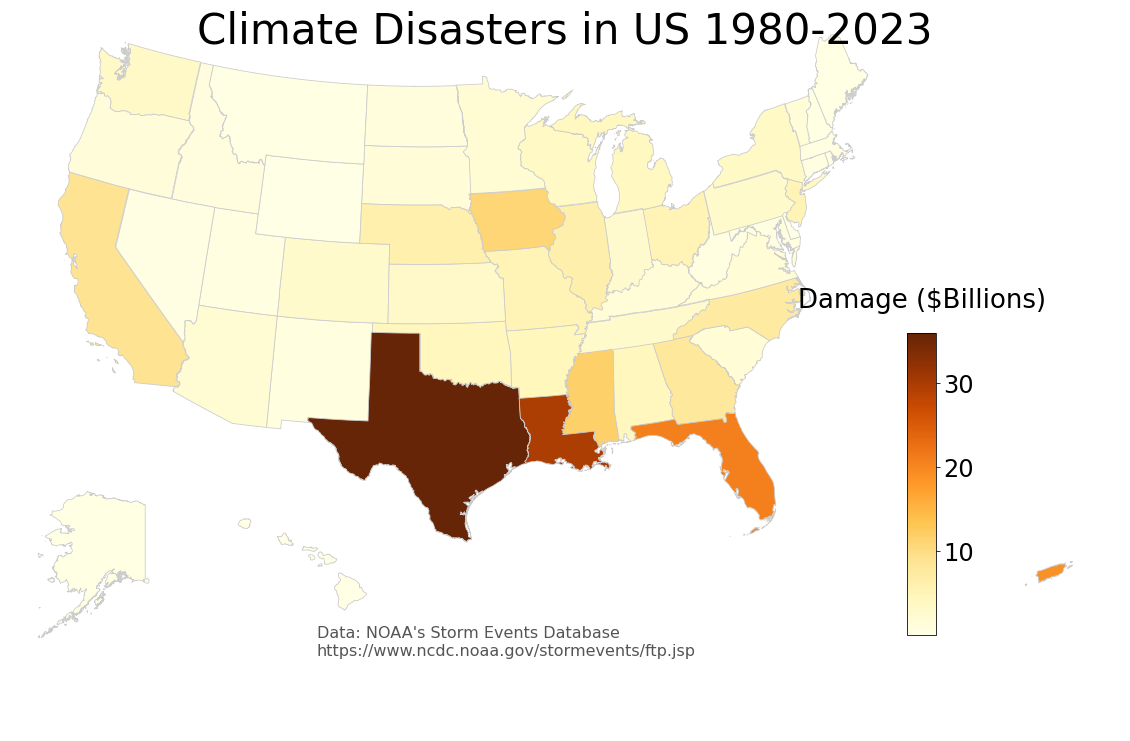

In [19]:
variable = 'DAMAGE'
label = 'Damage ($Billions)'
save_name = 'disasters_damage_by_state_1980_2023.png'
plot_disasters_map(gdf, variable, label, save_name, 'Climate Disasters in US 1980-2023', "Data: NOAA's Storm Events Database\nhttps://www.ncdc.noaa.gov/stormevents/ftp.jsp")

# House Price Index Analysis:

* Reading and processing the House Price Index (HPI) data.
* Analyzing and visualizing the average HPI of U.S. counties over time.
* Creating a heatmap of HPI for U.S. counties.
* Examining the relationship between disasters and house price changes at different lags.
* Our house price dataset come from Federal Housing Finance Agency: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo
* We get 2783 counties' data in total 

In [20]:
hpi_county = read_excel_file("/dataset/HPI_AT_BDL_county.xlsx", 6)
hpi_county.head()

,State,County,FIPS code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,AL,Autauga,1001,1986,.,100.00,94.92,70.22
1,AL,Autauga,1001,1987,-2.22,97.78,92.81,68.66
2,AL,Autauga,1001,1988,3.80,101.49,96.33,71.26
3,AL,Autauga,1001,1989,4.33,105.88,100.51,74.35
4,AL,Autauga,1001,1990,-0.51,105.35,100.00,73.97


In [21]:
hpi_county['Year'] = hpi_county['Year'].astype(int)
hpi_county.sort_values(by=['State','County', 'Year'], inplace=True)
hpi_county['Annual Change (%)'] = pd.to_numeric(hpi_county['Annual Change (%)'], errors='coerce')
hpi_county['HPI'] = pd.to_numeric(hpi_county['HPI'], errors='coerce')
hpi_county['lag1_hpi_change'] = (hpi_county.groupby(['State','County'])['HPI'].shift(periods=-1) / hpi_county.groupby(['State','County'])['HPI'].shift(periods=1) - 1) * 100
hpi_county['lag3_hpi_change'] = (hpi_county.groupby(['State','County'])['HPI'].shift(periods=-3) / hpi_county.groupby(['State','County'])['HPI'].shift(periods=1) - 1) * 100
hpi_county['lag5_hpi_change'] = (hpi_county.groupby(['State','County'])['HPI'].shift(periods=-5) / hpi_county.groupby(['State','County'])['HPI'].shift(periods=1) - 1) * 100
hpi_county['lag10_hpi_change'] = (hpi_county.groupby(['State','County'])['HPI'].shift(periods=-10) / hpi_county.groupby(['State','County'])['HPI'].shift(periods=1) - 1) * 100
hpi_county = hpi_county[hpi_county['Year'] >= 1980]

In [22]:
hpi_county.groupby(['State', 'County']).size()

State  County              
AK     Anchorage               43
       Fairbanks North Star    43
       Juneau                  43
       Kenai Peninsula         39
       Ketchikan Gateway       38
                               ..
WY     Sweetwater              43
       Teton                   37
       Uinta                   41
       Washakie                31
       Weston                  27
Length: 2783, dtype: int64

In [23]:
hpi_county.reset_index(inplace=True)
hpi_county.drop_duplicates(subset=['State', 'County', 'Year'], keep='first', inplace=True)

* Average house price of us counties has tripled from 1980 to 2023

In [24]:
avg_hpi_year = hpi_county.groupby(['Year'])['HPI'].mean()
avg_hpi_year = avg_hpi_year / avg_hpi_year[1980] * 100

In [25]:
plot_scatter_line(list(avg_hpi_year.index), avg_hpi_year.values, name='Average HPI', title='Average House Price Index of US Counties 1980-2023', x_title='Year', y_title="Average HPI", filename='Average House Price Index of US Counties 1980-2023.html')

* From the below heatmap, we can see there are significant differences of house price among various counties

In [26]:
heatmap_hpi = hpi_county.pivot_table(values='HPI', index=['State', 'County'], columns='Year')

In [27]:
plot_heatmap(heatmap_hpi, title='House Price Index of US Counties 1980-2023', x_title='Year', y_title='County', filename='House Price Index of US Counties 1980-2023.html')

# Statistical Testing:

* Conducting statistical tests (e.g., t-tests) to compare house price changes in heavily-affected counties and neighboring less-affected counties.


Disasters and house price relation analysis and visualization
* It is hard to find pattern of their relations by drawing yearly change at macro level

In [28]:
plot_two_scatter_lines(year_list, year_freq, avg_hpi_year.values, name1='Frequency', name2="House Price", title='Disasters Frequency & House Price Index of US 1980-2023', x_title='Year', y_title1="Frequency", y_title2='House Price', filename='Disasters Frequency & House Price Index of US 1980-2023.html')

In [29]:
county_freq = storm.groupby(['STUSPS','CZ_NAME','YEAR'])['EVENT_ID'].count()
county_damage = storm.groupby(['STUSPS','CZ_NAME','YEAR'])['DAMAGE'].sum()
county_year = pd.merge(county_freq, county_damage, left_index=True, right_index=True)
county_year.reset_index(inplace=True)
county_year['CZ_NAME'] = county_year['CZ_NAME'].str.title()
county_year.rename(columns={'EVENT_ID':'FREQ'}, inplace=True)

In [30]:
county_storm_hpi = pd.merge(county_year, hpi_county, left_on=['STUSPS','CZ_NAME','YEAR'], right_on=['State','County','Year'], how = 'right')
print(county_storm_hpi.duplicated(subset=['State', 'County', 'Year'], keep=False).sum())
county_storm_hpi.drop_duplicates(subset=['State', 'County', 'Year'], keep='first', inplace=True)

512


In [31]:
storm_hpi = county_storm_hpi[ ~ (county_storm_hpi['Year'] < 1980)]
storm_hpi['DAMAGE'] = storm_hpi['DAMAGE'].fillna(0)# If a county of a year has nan value, means this county didn't have disasters this year.
storm_hpi['FREQ'] = storm_hpi['FREQ'].fillna(0)
storm_hpi.sort_values(by=['State','County', 'Year'], inplace=True)
storm_hpi['lag_damage'] = storm_hpi.groupby(['State','County'])['DAMAGE'].shift(periods=1)
storm_hpi['lag_freq'] = storm_hpi.groupby(['State','County'])['FREQ'].shift(periods=1)
storm_hpi['damage_change'] = storm_hpi['DAMAGE'] - storm_hpi['lag_damage']
storm_hpi['freq_change'] = storm_hpi['FREQ'] - storm_hpi['lag_freq']
storm_hpi.head()

,STUSPS,CZ_NAME,YEAR,FREQ,DAMAGE,index,State,County,FIPS code,Year,...,HPI with 1990 base,HPI with 2000 base,lag1_hpi_change,lag3_hpi_change,lag5_hpi_change,lag10_hpi_change,lag_damage,lag_freq,damage_change,freq_change
0,NaN,NaN,NaN,0.0,0.0,2088,AK,Anchorage,2020,1980,...,83.21,57.33,25.545424,52.529551,52.272881,20.128335,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.0,0.0,2089,AK,Anchorage,2020,1981,...,104.51,72.00,41.259545,59.233732,46.942361,34.833435,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,0.0,0.0,2090,AK,Anchorage,2020,1982,...,117.55,80.98,21.493517,21.289073,1.748534,10.690267,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,0.0,0.0,2091,AK,Anchorage,2020,1983,...,126.98,87.47,12.724229,4.022961,-4.372160,-0.722315,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,0.0,0.0,2092,AK,Anchorage,2020,1984,...,132.50,91.28,-0.168276,-16.251882,-22.008679,-5.495527,0.0,0.0,0.0,0.0


In [32]:
gdf = read_gpd_file("/dataset/cb_2022_us_county_500k")
gdf_polygon = gdf[['STUSPS','NAME','geometry']]
storm_hpi = pd.merge(storm_hpi, gdf_polygon, left_on=['State','County'], right_on=['STUSPS','NAME'], how = 'left')
storm_hpi.drop_duplicates(subset=['State', 'County', 'Year'], keep='first', inplace=True)
storm_hpi.dropna(subset=['geometry'], inplace=True)
data = storm_hpi.copy()

### Damage and freq's absolute values' relationships with house price change
* Both of Damage and frequency have significant negative impact on house price change of the events' happened current year, lag 1 year and lag 3 years.
* Compared with damage, frequency has higher negative correlation and smaller p_value.

In [33]:
damage_hpi_corr = []
damage_hpi_p = []
freq_hpi_corr = []
freq_hpi_p = []
damage_c_hpi_corr = []
damage_c_hpi_p = []
freq_c_hpi_corr = []
freq_c_hpi_p = []
col = ['Annual Change (%)','lag1_hpi_change','lag3_hpi_change','lag5_hpi_change','lag10_hpi_change']
storm_hpi = data.copy()
for i in col:
    storm_hpi.dropna(subset=[i], inplace=True)
    corr, p_value = cal_pearsonr(storm_hpi['DAMAGE'], storm_hpi[i])
    damage_hpi_corr.append(corr)
    damage_hpi_p.append(p_value)
    corr, p_value = cal_pearsonr(storm_hpi['FREQ'], storm_hpi[i])
    freq_hpi_corr.append(corr)
    freq_hpi_p.append(p_value)
storm_hpi = data.copy()
for i in col:
    storm_hpi.dropna(subset=[i,'damage_change', 'freq_change'], inplace=True)
    corr, p_value = cal_pearsonr(storm_hpi['damage_change'], storm_hpi[i])
    damage_c_hpi_corr.append(corr)
    damage_c_hpi_p.append(p_value)
    corr, p_value = cal_pearsonr(storm_hpi['freq_change'], storm_hpi[i])
    freq_c_hpi_corr.append(corr)
    freq_c_hpi_p.append(p_value)

In [34]:
corr_data = [freq_hpi_corr, damage_hpi_corr]
p_data = [freq_hpi_p, damage_hpi_p]
corr_p = cal_corr_p(corr_data, p_data)

In [35]:
x = ['Disaster Year','1-Year Lag','3-Year Lag','5-Year Lag','10-Year Lag']
y = ['Frequency','Damage']
plot_correlation(corr_data, corr_p, x, y, title='Correlation Coefficient of Disasters & House Price Change', filename='Correlation Coefficient of Disasters & House Price Change.html')

## Using nearest county to do paired sample t test of house price change 

### Divide counties into heavily affected group and less-affected group according to frequency
* Price change of heavily affected group is negative compared with less-affected group
* This difference is significant by using paired sample t test.

In [36]:
storm_hpi = data.copy()
county_freq = storm_hpi.groupby(['State', 'County'])['FREQ'].sum()
county_freq = pd.DataFrame(county_freq)
county_freq.reset_index(inplace=True)
print(county_freq.shape)
county_freq = pd.merge(county_freq, gdf_polygon, left_on=['State','County'], right_on=['STUSPS','NAME'], how = 'left')
county_freq.drop_duplicates(subset=['State','County'], keep='first', inplace=True)
county_freq.drop(columns=['STUSPS','NAME'], inplace=True)
print(county_freq.shape)

(2681, 3)
(2681, 4)


In [37]:
quantile_25 = county_freq['FREQ'].quantile(0.25)
quantile_75 = county_freq['FREQ'].quantile(0.75)
county_freq_l = county_freq[county_freq['FREQ'] < quantile_25]
county_freq_h = county_freq[county_freq['FREQ'] > quantile_75]
print(county_freq_h.shape)
print(county_freq_l.shape)
county_freq_l.drop(columns=['FREQ'], inplace=True)
county_freq_h.drop(columns=['FREQ'], inplace=True)
county_freq_l = county_freq_l.reset_index(drop=True)

(668, 4)
(669, 4)


In [38]:
county_h = county_freq_h.copy()
county_h['affected_level'] = 'high'
county_l = county_freq_l.copy()
county_l['affected_level'] = 'low'
county_map = pd.concat([county_h, county_l], axis=0)
county_map.drop(columns='geometry', inplace=True)
gdf = read_gpd_file("/dataset/cb_2022_us_county_500k")
gdf = pd.merge(gdf, county_map,left_on=['STUSPS','NAME'],right_on=['State','County'],how='left')
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,State,County,affected_level
0,01,069,00161560,0500000US01069,01069,Houston,Houston County,AL,Alabama,06,1501742235,4795415,"POLYGON ((-85.71209 31.19727, -85.70934 31.198...",AL,Houston,high
1,01,023,00161537,0500000US01023,01023,Choctaw,Choctaw County,AL,Alabama,06,2365900083,19114321,"POLYGON ((-88.47323 31.89386, -88.46888 31.930...",AL,Choctaw,low
2,01,005,00161528,0500000US01005,01005,Barbour,Barbour County,AL,Alabama,06,2292160151,50523213,"POLYGON ((-85.74803 31.61918, -85.74544 31.618...",NaN,NaN,NaN
3,01,107,00161580,0500000US01107,01107,Pickens,Pickens County,AL,Alabama,06,2282835044,22621093,"POLYGON ((-88.34043 32.99120, -88.33101 33.072...",NaN,NaN,NaN
4,01,033,00161542,0500000US01033,01033,Colbert,Colbert County,AL,Alabama,06,1535742270,79160396,"POLYGON ((-88.13925 34.58779, -88.13872 34.589...",AL,Colbert,high


In [39]:
gdf.drop_duplicates(subset=['STUSPS','NAME'], keep='first', inplace=True)
gdf = gdf[~ gdf['STATE_NAME'].isin(['Commonwealth of the Northern Mariana Islands', 'District of Columbia', 'United States Virgin Islands','American Samoa','Guam','Hawaii','Alaska'])]
gdf.shape

(3180, 16)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


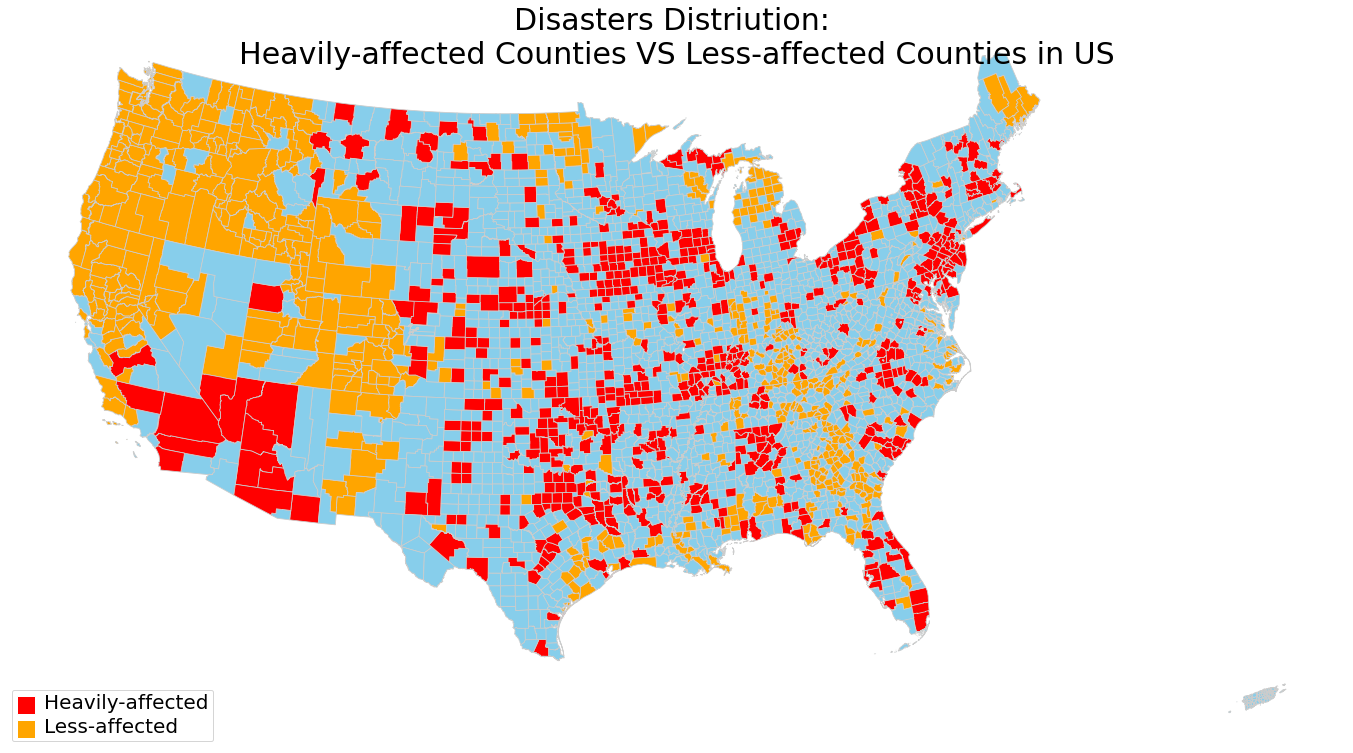

In [40]:
save_name = 'disasters_affected_level_by_county_1980_2023.png'
plot_disasters_map1(gdf, save_name, 'Disasters Distriution: \nHeavily-affected Counties VS Less-affected Counties in US', 'Heavily-affected', 'Less-affected')

In [41]:
county_h = get_nearest_county(county_freq_h, county_freq_l)
county_h.drop(columns='geometry', inplace=True)
storm_hpi_h = pd.merge(storm_hpi, county_h, on=['State','County'], how='inner')
print(storm_hpi_h.shape)
keep_cols = ['FREQ', 'DAMAGE', 'State', 'County','Year', 'Annual Change (%)', 'HPI','lag1_hpi_change', 'lag3_hpi_change','lag5_hpi_change', 'lag10_hpi_change','lag_damage', 'lag_freq', 'damage_change', 'freq_change','geometry', 'neighbor_state', 'neighbor_county',
       'neighbor_distance']
storm_hpi_h = storm_hpi_h[keep_cols]
storm_hpi_h.shape
storm_hpi_l =storm_hpi[['FREQ', 'DAMAGE', 'State', 'County','Year', 'Annual Change (%)', 'HPI','lag1_hpi_change', 'lag3_hpi_change','lag5_hpi_change', 'lag10_hpi_change','lag_damage', 'lag_freq', 'damage_change', 'freq_change']]
storm_hpi_h = pd.merge(storm_hpi_h, storm_hpi_l, left_on=['neighbor_state', 'neighbor_county', 'Year'], right_on=['State', 'County','Year'], suffixes=('_h', '_l'))
storm_hpi_ttest_h= storm_hpi_h.copy()
storm_hpi_h.head()

(25577, 28)


,FREQ_h,DAMAGE_h,State_h,County_h,Year,Annual Change (%)_h,HPI_h,lag1_hpi_change_h,lag3_hpi_change_h,lag5_hpi_change_h,...,Annual Change (%)_l,HPI_l,lag1_hpi_change_l,lag3_hpi_change_l,lag5_hpi_change_l,lag10_hpi_change_l,lag_damage_l,lag_freq_l,damage_change_l,freq_change_l
0,6.0,0.190,AL,Baldwin,2006,17.05,373.19,19.612948,5.846559,-12.728185,...,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,0.040,AL,Mobile,2006,14.81,398.18,22.787037,20.832132,5.567730,...,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17.0,0.473,AL,Baldwin,2007,2.18,381.35,-2.221389,-20.523058,-25.190922,...,7.67,107.67,13.990000,5.670000,2.660000,8.930000,0.750,1.0,-0.238,3.0
3,22.0,4.501,AL,Mobile,2007,6.95,425.85,8.292732,-2.152293,-11.632930,...,7.67,107.67,13.990000,5.670000,2.660000,8.930000,0.750,1.0,-0.238,3.0
4,20.0,0.187,AL,Baldwin,2008,-4.31,364.90,-11.509112,-27.038154,-25.776845,...,5.87,113.99,2.024705,-5.600446,-1.755364,6.482771,0.512,4.0,-0.459,6.0


In [42]:
h_year = storm_hpi_h.groupby('Year')['Annual Change (%)_h'].mean()
l_year = storm_hpi_h.groupby('Year')['Annual Change (%)_l'].mean()

In [43]:
name1 = 'Heavily-affected Counties'
name2 = 'Neighboring Less-affected Counties'
title = "Average House Price Change (%) <br>of Disasters' Happened Year"
filename = "Average House Price Change for Disasters Happened Year"
legend = dict(x=0.02, y=1.0, font=dict(size=16))
plot_two_lines(list(h_year.index),list(h_year.index), h_year.values, l_year.values, name1, name2, title, "Year","Percentage", legend, filename+'.html')

In [44]:
h_year_10 = storm_hpi_h.groupby('Year')['lag10_hpi_change_h'].mean()
l_year_10 = storm_hpi_h.groupby('Year')['lag10_hpi_change_l'].mean()
h_year_10.dropna(inplace=True)
l_year_10.dropna(inplace=True)
name1 = 'Heavily-affected Counties'
name2 = 'Neighboring Less-affected Counties'
title = "Average House Price Change (%) <br>of 10-Year Lag after Disasters' Happened"
filename = "Average House Price Change for 10-Year Lag after Disasters Happened"
legend = dict(x=0.02, y=0.02, font=dict(size=16))
year_list = [i for i in range(1990, 2023)]
plot_two_lines(year_list,year_list, h_year_10.values, l_year_10.values, name1, name2, title, "Year","Percentage", legend, filename+'.html')

In [45]:
cols = [('Annual Change (%)_h','Annual Change (%)_l'),('lag1_hpi_change_h','lag1_hpi_change_l'),('lag3_hpi_change_h','lag3_hpi_change_l'),('lag5_hpi_change_h','lag5_hpi_change_l'),('lag10_hpi_change_h','lag10_hpi_change_l')]
storm_hpi_h = storm_hpi_ttest_h.copy()
mean_diff_freq,t_freq,p_freq = cal_freq(cols, storm_hpi_h)

In [46]:
year_list = ['Disaster Year','1-Year Lag','3-Year Lag','5-Year Lag','10-Year Lag']
mean_diff_freq = [round(f,2) for f in mean_diff_freq]
freq_labels = [f"{diff} {'***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''}" for diff, p in zip(mean_diff_freq, p_freq)]

In [47]:
plot_reverse_bars(year_list, mean_diff_freq, freq_labels, "Frequency", 'Difference of House Price Change (%):<br> Heavily-affected Counties minus Neighboring Less-affected Counties', 'Year', 'Difference(%)', 'Difference of House Price Change Heavily-affected Counties minus Neighboring Less-affected Counties.html')